In [1]:
! ls

 HNC-1				      data
 Untitled.ipynb			      data_img
'checkpoint_state1_noflip(100).pth'   dataset.ipynb
'checkpoint_state2_noflip(50).pth'    rnn_torchviz
'checkpoint_state3_flip(50).pth'      unet-resnet18.ipynb


In [2]:
import glob
import multiprocessing as mp
import os
import re
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pydicom
from matplotlib.image import imsave as imgSave
from PIL import Image, ImageDraw


In [3]:
string = 'HNNLAP-037'
re.findall( '[0-9]{3}$', string )


['037']

In [ ]:
"""# unzip
zip_folder_path = os.path.join( '.', 'data' )

for zip_path in glob.glob( os.path.join( zip_folder_path, '*.zip' ) ):
    file_name = re.split( '\.|/|\\\\', glob.glob( os.path.join( '.', 'data', '*.zip' ) )[ 0 ] )[ -2 ]
    with zipfile.ZipFile( zip_path, 'r' ) as zip_ref:
        zip_ref.extractall( os.path.join( zip_folder_path, file_name ) )
"""

In [21]:
ds = pydicom.dcmread('data/vghtc/HNNLAP-053/RS.1.2.246.352.221.50346275514112259244412120538180860554.dcm')
[ds.ROIContourSequence[ 1 ].ContourSequence[ i ].ContourImageSequence[ 0 ].ReferencedSOPInstanceUID for i in range(10)]

['1.2.246.352.221.484751134372187105113903678954491954087',
 '1.2.246.352.221.50143565152126124236229953702795919777',
 '1.2.246.352.221.513721716772578721817623031102881968011',
 '1.2.246.352.221.55860385817281934214776732873517974165',
 '1.2.246.352.221.55860385817281934214776732873517974165',
 '1.2.246.352.221.52996151386819286162711558875485544380',
 '1.2.246.352.221.52996151386819286162711558875485544380',
 '1.2.246.352.221.472406492998662195218253742268550435502',
 '1.2.246.352.221.472406492998662195218253742268550435502',
 '1.2.246.352.221.546674492739937330212554839987381556398']

In [28]:
def convert_mm_to_pixel( di_ipp, di_iop, di_ps, contourData ):
    matrix_im = np.array(
        [
            [ di_iop[ 0 ] * di_ps[ 0 ], di_iop[ 3 ] * di_ps[ 1 ],
              np.finfo( np.float16 ).tiny, di_ipp[ 0 ] ],
            [ di_iop[ 1 ] * di_ps[ 0 ], di_iop[ 4 ] * di_ps[ 1 ],
              np.finfo( np.float16 ).tiny, di_ipp[ 1 ] ],
            [ di_iop[ 2 ] * di_ps[ 0 ], di_iop[ 5 ] * di_ps[ 1 ],
              np.finfo( np.float16 ).tiny, di_ipp[ 2 ] ], [ 0, 0, 0, 1 ]
        ] )
    inv_matrix_im = np.linalg.inv( matrix_im )
    contour_px = []

    for index, v in enumerate( [ contourData[ i:i + 3 ] for i in range( 0, len( contourData ), 3 ) ] ):
        v.append( 1 )
        i, j, trash, trash = [ int( np.around( i ) ) for i in inv_matrix_im.dot( np.array( v ) ) ]
        contour_px.append( ( i, j ) )

    return contour_px

In [29]:
def coutours_img( contourData_px, shape, mode: int = 0 ):
    img = Image.new( 'L', shape, 0 )
    for px in contourData_px:
        if mode == 0:
            ImageDraw.Draw( img ).polygon( px, outline=1, fill=1 )
        elif mode == 1:
            ImageDraw.Draw( img ).polygon( px, outline=1, fill=2 )
            ImageDraw.Draw( img ).line( px, fill=1, width=6 )
    return img

In [38]:
def mk_loc_and_show_image( data: dict, person: str, mode: int = 0 ):
    """0 : only loc, 1 : img, 2 : img & mask"""
    if mode == 0:
        for index, uid_and_loc in enumerate( sorted( data.items(), key=lambda x: x[ 1 ][ 'slice' ] ) ):
            data[ uid_and_loc[ 0 ] ][ 'loc' ] = index

    elif mode == 1:
        height = len( data.items() ) // 4 + 1
        size = 6
        fig = plt.figure( figsize=( 4 * size, height * size ) )  # width height

        for index, uid_and_loc in enumerate( sorted( data.items(), key=lambda x: x[ 1 ][ 'slice' ] ) ):
            data[ uid_and_loc[ 0 ] ][ 'loc' ] = index

            plt.subplot( height, 4, index + 1 )
            plt.imshow( data[ uid_and_loc[ 0 ] ][ "ctpx" ], cmap=plt.cm.bone )
            plt.axis( 'on' )
        plt.suptitle( person )
        plt.show()

    elif mode == 2:
        height = len( data.items() ) * 2 // 4 + 1
        size = 6
        fig = plt.figure( figsize=( 4 * size, height * size ) )  # width height

        for index, uid_and_loc in enumerate( sorted( data.items(), key=lambda x: x[ 1 ][ 'slice' ] ) ):
            data[ uid_and_loc[ 0 ] ][ 'loc' ] = index

            plt.subplot( height, 4, 2 * index + 1 )
            plt.imshow( data[ uid_and_loc[ 0 ] ][ "ctpx" ], cmap=plt.cm.bone )

            plt.subplot( height, 4, 2 * index + 2 )
            plt.imshow( data[ uid_and_loc[ 0 ] ][ "maskpx" ], cmap=plt.cm.gray )
            plt.axis( 'on' )
        plt.show()

    elif mode == 3:
        height = len( data.items() ) * 2 // 4 + 1
        size = 6
        fig = plt.figure( figsize=( 4 * size, height * size ) )  # width height

        for index, uid_and_loc in enumerate( sorted( data.items(), key=lambda x: x[ 1 ][ 'slice' ] ) ):
            data[ uid_and_loc[ 0 ] ][ 'loc' ] = index

            plt.subplot( height, 4, 2 * index + 1 )
            plt.title( f"{person}_{index}_img" )
            plt.imshow( data[ uid_and_loc[ 0 ] ][ "ctpx" ], cmap=plt.cm.bone )

            plt.subplot( height, 4, 2 * index + 2 )
            plt.title( f"{person}_{index}_mask" )
            plt.imshow( data[ uid_and_loc[ 0 ] ][ "maskpx" ], cmap=plt.cm.gray )
            plt.axis( 'on' )
        plt.show()

In [31]:
def save_dataset( data, savePath, person, mode: int = 0 ):
    os.makedirs( savePath, exist_ok=True )
    for uid, d in data.items():
        #print( uid )
        if mode == 0:
            Image.fromarray( d[ 'ctpx' ] ).save( os.path.join( savePath, f"{person}_{d[ 'loc' ]:03}_{d['label']:d}_ct.png" ), 'PNG' )
            d[ 'maskpx' ].save( os.path.join( savePath, f"{person}_{d[ 'loc' ]:03}_{d['label']:d}_mask.png" ), 'PNG' )

In [32]:
def process_data( path, dicom_ds: pydicom.dataset.FileDataset, person, showMode: int = 0 ):
    """showMode -> 0 : only loc, 1 : img, 2 : img & mask"""
    ContourImageSequence_from_ds = dicom_ds.ReferencedFrameOfReferenceSequence[ 0 ].RTReferencedStudySequence[
        0 ].RTReferencedSeriesSequence[ 0 ].ContourImageSequence
    number_ct = len( ContourImageSequence_from_ds )

    data = {}

    for index, ct_id in enumerate( [ ContourImageSequence_from_ds[ i ].ReferencedSOPInstanceUID for i in range( number_ct ) ] ):
        #print( ct_id )
        ds = pydicom.dcmread( os.path.join( path, 'CT.' + ct_id + ".dcm" ) )
        uid = ds.SOPInstanceUID
        if ( uid != ct_id ): print( 'uneq' )

        data[ uid ] = {
            'slice': ds.SliceLocation,
            'loc': None,
            'spacing': ds.PixelSpacing,
            'position': ds.ImagePositionPatient,
            'orientation': ds.ImageOrientationPatient,
            'ctpx': ds.pixel_array,
            'label': False,
            'mask': None,
            'maskT': None,
            'maskpx': Image.new( 'L', ds.pixel_array.shape, 0 )
        }

    for i in range( len( dicom_ds.StructureSetROISequence ) ):
        if dicom_ds.StructureSetROISequence[ i ].ROIName == "LAP":
            #print(len(dicom_ds.ROIContourSequence),i)
            for seq in dicom_ds.ROIContourSequence[ i ].ContourSequence:
                ruid = seq.ContourImageSequence[ 0 ].ReferencedSOPInstanceUID
                data[ ruid ][ 'mask' ] = arr_mm = seq.ContourData
                data[ ruid ][ 'label' ] = True
                # point data
                if data[ ruid ][ 'maskT' ] is not None:
                    data[ ruid ][ 'maskT' ].append(
                        convert_mm_to_pixel(
                            data[ ruid ][ 'position' ], data[ ruid ][ 'orientation' ], data[ ruid ][ 'spacing' ], arr_mm ) )
                else:
                    data[ ruid ][ 'maskT' ] = [
                        convert_mm_to_pixel(
                            data[ ruid ][ 'position' ], data[ ruid ][ 'orientation' ], data[ ruid ][ 'spacing' ], arr_mm )
                    ]
                data[ ruid ][ 'maskpx' ] = coutours_img( data[ ruid ][ 'maskT' ], data[ ruid ][ 'ctpx' ].shape )
                # print(type(px))
        else:
            # print(dicom_ds.StructureSetROISequence[ i ].ROIName)
            pass

    mk_loc_and_show_image( data=data, person=person, mode=showMode )
    # save_dataset( data=data, savePath='./vghtc_contours_data/train', person=PERSON )  # have uo use in hight level
    return data


In [33]:
def load_folder( path, savePath, split: int = 25, mode: tuple = ( 0, 0 ), multiprocess: bool = True ):
    """mode -> ( save, show)"""
    os.makedirs( savePath, exist_ok=True )

    def single_task( folder_path ):
        person = re.findall( '[0-9]{3}$', folder_path.split( os.sep )[ -1 ] )[ 0 ]
        print( person )

        save_path = savePath # os.path.join( savePath, 'test' if int( person ) > 25 else 'train' )

        for rt_name in glob.glob( os.path.join( folder_path, 'RS*.dcm' ) ):
            dicom_ds = pydicom.dcmread( rt_name )
            if ( dicom_ds.Modality != "RTSTRUCT" ):
                raise TypeError( 'dicom_ds.Modality != RTSTRUCT' )
            if 'LAP' not in [ StructureSetROI.ROIName for StructureSetROI in dicom_ds.StructureSetROISequence ]:
                print( f"rt file {rt_name} without LAP contours" )
                continue

            data = process_data( path=folder_path, dicom_ds=dicom_ds, person=person, showMode=mode[ 1 ] )
            save_dataset( data=data, savePath=save_path, person=person, mode=mode[ 0 ] )

    if multiprocess is True:
        print( 'multi processing on' )
        cpu_count = mp.cpu_count()
        print( "cpu_count: ", cpu_count )
        process_list = []
        for folder_path in glob.glob( os.path.join( path, '*' ) ):
            process_list.append( mp.Process( target=single_task, args=( folder_path, ) ) )
            process_list[ -1 ].start()

    else:
        print( 'single processing on' )
        for folder_path in glob.glob( os.path.join( path, '*' ) ):
            single_task( folder_path=folder_path )


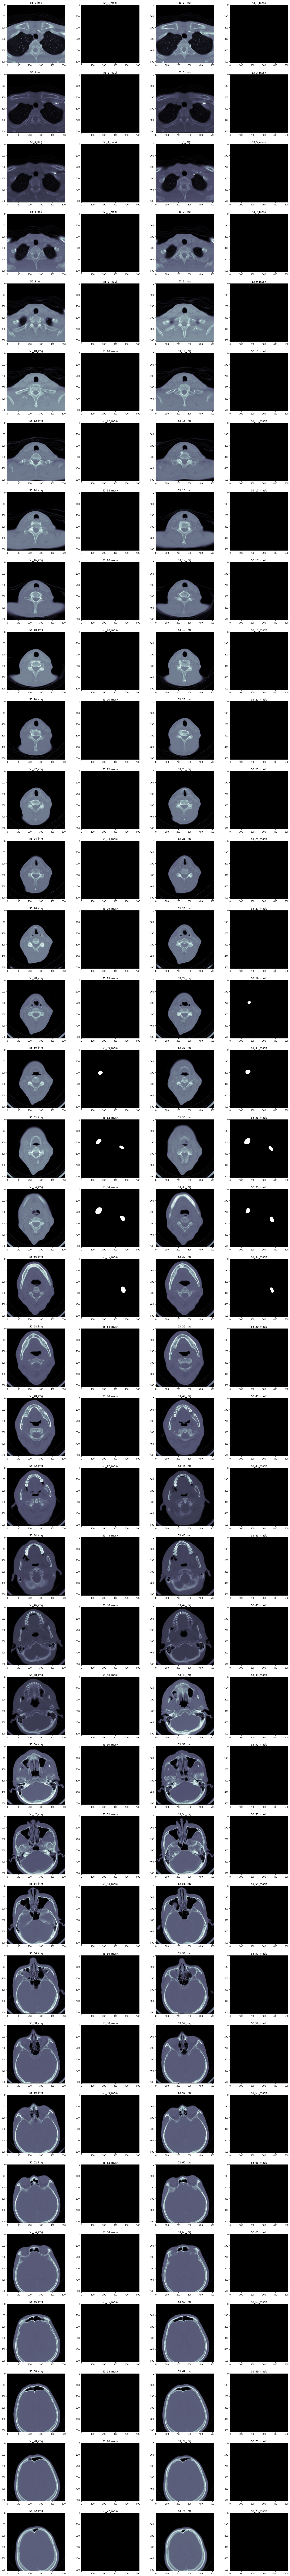

{'1.2.246.352.221.48603300878270128512734846037547489684': {'slice': '-284.79',
  'loc': 0,
  'spacing': [0.390625, 0.390625],
  'position': [-100, 52.1, -284.79],
  'orientation': [1, 0, 0, 0, 1, 0],
  'ctpx': array([[   3,    2,    2, ...,    2,    1,    0],
         [   2,    2,    4, ...,    1,    0,    0],
         [   0,    2,    6, ...,    1,    0,    0],
         ...,
         [1063, 1061, 1059, ..., 1052, 1050, 1049],
         [1063, 1064, 1064, ..., 1036, 1034, 1036],
         [1056, 1058, 1060, ..., 1029, 1025, 1030]], dtype=uint16),
  'label': False,
  'mask': None,
  'maskT': None,
  'maskpx': <PIL.Image.Image image mode=L size=512x512 at 0x7FE488D9FE48>},
 '1.2.246.352.221.505760223163832902213209720297377927821': {'slice': '-280.79',
  'loc': 1,
  'spacing': [0.390625, 0.390625],
  'position': [-100, 52.1, -280.79],
  'orientation': [1, 0, 0, 0, 1, 0],
  'ctpx': array([[   3,    2,    4, ...,   12,   10,    9],
         [   7,    7,    7, ...,    9,   12,   12],
        

In [39]:
process_data( 'data/vghtc/HNNLAP-053', pydicom.dcmread( 'data/vghtc/HNNLAP-053/RS.1.2.246.352.221.50346275514112259244412120538180860554.dcm' ), 53, 3 )

In [41]:
data_from = 'vghtc'
data_dicom_folder = os.path.join( '.', 'data', data_from )
data_img_folder = os.path.join( '.', 'data_img', data_from )
load_folder( path=data_dicom_folder, savePath=data_img_folder, mode=( 0, 0 ), multiprocess=True )

multi processing on
cpu_count:  32
022
046
045
004
015
027
039
042
023
029
057
053
028
026
019
012
055
007
020
013
016
049
030
035
011
014
054
050
018
024
021
008
048
006
051
033
036
017
038
005
002
003
043
044
047
001
058
037
032
056
009
031
025
040
010
034
052
041
rt file ./data/vghtc/HNNLAP-044/RS.1.2.246.352.221.564349196323003941117297893638696200356.dcm without LAP contours
rt file ./data/vghtc/001/RS.1.2.246.352.221.478677787149761761413858561478778497710.dcm without LAP contours
